In [1]:
import os
import json
from pycocotools.coco import COCO
import cv2
import random
import matplotlib.pyplot as plt

# Paths
annotation_file = 'annotations/instances_default.json'
resized_annotation_file = 'resized_annotations/annotations_train.json'
target_size = (320, 240)

# Load COCO annotations
coco = COCO(annotation_file)

# Get image IDs
img_ids = coco.getImgIds()
image_id_length = len(img_ids)
print("Total image IDs:", image_id_length)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total image IDs: 278


In [2]:
def resize_bboxes(bboxes, original_size, target_size):
    x_scale = target_size[0] / original_size[0]
    y_scale = target_size[1] / original_size[1]
    resized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, width, height = bbox
        x_min = x_min * x_scale
        y_min = y_min * y_scale
        width = width * x_scale
        height = height * y_scale
        resized_bboxes.append([x_min, y_min, width, height])
    return resized_bboxes


In [3]:
# Initialize lists to hold resized annotation data
resized_images = []
resized_annotations = []
annotation_id = 0

for i in range(image_id_length):
    img_info = coco.loadImgs(img_ids[i])[0]
    
    # Update image info for the resized image
    original_size = (img_info['width'], img_info['height'])
    img_info['width'] = target_size[0]
    img_info['height'] = target_size[1]
    resized_images.append(img_info)
    
    # Get and resize the annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_ids[i])
    annotations = coco.loadAnns(ann_ids)
    
    bboxes = [ann['bbox'] for ann in annotations]
    resized_bboxes = resize_bboxes(bboxes, original_size, target_size)
    
    # Update annotations for the resized image
    for j, ann in enumerate(annotations):
        ann['bbox'] = resized_bboxes[j]
        ann['image_id'] = img_ids[i]
        ann['id'] = annotation_id
        resized_annotations.append(ann)
        annotation_id += 1

print("Resizing annotations completed.")

# Save resized annotations to a new JSON file
resized_coco_format = {
    "info": coco.dataset["info"],
    "licenses": coco.dataset["licenses"],
    "images": resized_images,
    "annotations": resized_annotations,
    "categories": coco.dataset["categories"]
}

os.makedirs(os.path.dirname(resized_annotation_file), exist_ok=True)
with open(resized_annotation_file, 'w') as f:
    json.dump(resized_coco_format, f)

print(f"Resized annotations saved to {resized_annotation_file}")


Resizing annotations completed.
Resized annotations saved to resized_annotations/annotations_train.json


{'id': 50, 'width': 320, 'height': 240, 'file_name': '09_48_06_darker.jpg', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}


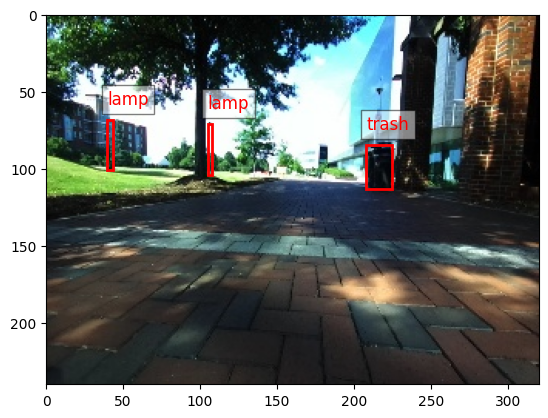

In [7]:
# Load the resized COCO annotations
with open(resized_annotation_file, 'r') as f:
    resized_coco = json.load(f)

category_id_to_name = {category['id']: category['name'] for category in resized_coco['categories']}


random_img_info = random.choice(resized_coco['images'])
image_dir = 'resized_dataset/Train'
print(random_img_info)
random_img_id = random_img_info['id']


random_annotations = [ann for ann in resized_coco['annotations'] if ann['image_id'] == random_img_id]

def display_annotations(image_info, annotations, category_id_to_name):
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image_rgb)
    
    ax.set_xlim(0, image_info['width'])
    ax.set_ylim(image_info['height'], 0)
    
    for ann in annotations:
        bbox = ann['bbox']
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = category_id_to_name[ann['category_id']]
        # Add text label
        plt.text(x_min, y_min - 10, label, fontsize=12, color='red', bbox=dict(facecolor='white', alpha=0.5))

    plt.show()

# Display the annotations
display_annotations(random_img_info, random_annotations, category_id_to_name)
